In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from indigo import *
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

from bokeh.io import output_notebook, export_png
from bokeh.layouts import row
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, Legend, ColumnDataSource
from typing import List

In [2]:
output_notebook()

Loading BokehJS ...

### Some global variables used throughout this notebook

In [3]:
PATH = "Adrenergic_dataset.csv"
FOLDS = 5
SEED = 12
#TARGET =  "AdrA1B_PCHEMBL_VALUE"
TARGET =  "logP"

columns = ["Structure", "ID", TARGET]

### Read data from csv

In [4]:
df = pd.read_csv(PATH)
df.head()

,Structure,ID,logP,Vx,MW,NegativeCharge,PositiveCharge,Flex,AromaticRings,OverallCharge,...,q485,frg-8,frg-26,frg-54,Nn,AdrA1A_PCHEMBL_VALUE,AdrA1B_PCHEMBL_VALUE,AdrA1D_PCHEMBL_VALUE,AdrA2A_PCHEMBL_VALUE,AdrA2C_PCHEMBL_VALUE
0,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,CHEMBL411,4.871,224.4,268.4,0,0,0.1905,2,0,...,4,2,0,0,0,NaN,NaN,NaN,NaN,5.66
1,CSc1ccc2Sc3ccccc3N(CCC4CCCCN4C)c2c1,CHEMBL479,5.900,290.2,370.6,0,2,0.1429,2,2,...,18,0,0,0,2,NaN,NaN,NaN,NaN,7.60
2,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1,CHEMBL2205811,3.040,225.5,309.4,0,1,0.1379,1,1,...,4,0,0,0,1,NaN,NaN,NaN,NaN,6.25
3,COc1cc(CN[C@H]2C3C4CC5C6C4CC3C6C25)cc(OC)c1OC,CHEMBL2432051,3.380,256.3,341.4,0,1,0.2000,1,1,...,8,0,0,0,1,NaN,NaN,NaN,NaN,5.64
4,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1OC,CHEMBL2205813,2.899,245.4,339.4,0,1,0.1613,1,1,...,6,0,0,0,1,NaN,NaN,NaN,NaN,5.36


### Drop NA values from assay value column

In [5]:
dataset = df[columns]
dataset.dropna(subset=[TARGET], inplace=True)

In [6]:
indigo = Indigo()


def get_fingerprints(dataset: pd.DataFrame):
    indigo.setOption("ignore-stereochemistry-errors", True)
    indigo.setOption("ignore-bad-valence", True)
    indigo.setOption("similarity-type", "ecfp6")
    indigo.setOption("fp-sim-qwords", 8)
    indigo.setOption("fp-ord-qwords", 25)
    indigo.setOption("fp-any-qwords", 15)
    indigo.setOption("fp-tau-qwords", 25)
    indigo.setOption("fp-ext-enabled", True)
    fingerprints = []
    max_val = -np.Inf

    for struct in dataset["Structure"]:
        mol = indigo.loadMolecule(struct)
        mol.aromatize()
        fingerprint = mol.fingerprint("full").toBuffer()
        buffered = np.frombuffer(fingerprint, dtype=np.uint8)
        buffered = np.unpackbits(buffered)
        fingerprints.append(buffered)
        max_val = max(max_val, *buffered)

    fingerprints = np.array(fingerprints, dtype=np.float32) / max_val
    return fingerprints


fingerprints = get_fingerprints(dataset)
dataset.head()

,Structure,ID,logP
0,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,CHEMBL411,4.871
1,CSc1ccc2Sc3ccccc3N(CCC4CCCCN4C)c2c1,CHEMBL479,5.900
2,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1,CHEMBL2205811,3.040
3,COc1cc(CN[C@H]2C3C4CC5C6C4CC3C6C25)cc(OC)c1OC,CHEMBL2432051,3.380
4,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1OC,CHEMBL2205813,2.899


### Draw distribution plot for assay values

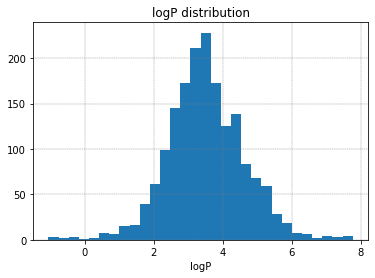

In [7]:
def make_plot():
    x = dataset[TARGET]
    n, bins, patches = plt.hist(x, 30)

    #plt.style.use('classic')
    plt.xlabel(TARGET)
    plt.title(f'{TARGET} distribution')
    plt.grid(True, color = "grey", linewidth = "0.4", linestyle = "dashed")
    plt.show()

make_plot()

In [8]:
import base64
from indigo.renderer import IndigoRenderer


indigo = Indigo()
renderer = IndigoRenderer(indigo)
indigo.setOption("render-output-format", "svg")
indigo.setOption("render-image-size", 350, 170)


def molecule_image(smiles: str) -> str:
    mol = indigo.loadMolecule(smiles)
    mol.aromatize()
    svg = renderer.renderToString(mol)
    return "data:image/svg+xml;base64," + base64.b64encode(svg.encode()).decode()


def avp_plot(actual: List[float], predicted: List[float], ids: List[str], smiles_list: List[str], r2: float) -> None:
    df = pd.DataFrame({'x': actual, 'y': predicted})
    df["id"] = ids
    df["image"] = [molecule_image(smiles) for smiles in smiles_list]
    df['residual'] = actual - predicted
    plot_height = 400
    plot_width = int(plot_height * 1.4)
    plot_figure = figure(
        title=f"{TARGET} Actual vs Predicted, r2={r2}",
        plot_width=plot_width,
        plot_height=plot_height,
        x_axis_label="Actual",
        y_axis_label="Predicted",
        tools="pan, wheel_zoom, reset",
    )
    plot_figure.add_tools(
        HoverTool(
        tooltips="""
            <div>
            <div>
            <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
            </div>
            <div>
            <span style='font-size: 16px; color: #224499'>Compound:</span>
            <span style='font-size: 18px'>@id</span>
            </div>
            <div>
            <span style='font-size: 16px; color: #224499'>Residual:</span>
            <span style='font-size: 18px'>@residual</span>
            </div>
            </div>
            """
        )
    )
    plot_figure.add_layout(Legend(), "right")
    datasource = ColumnDataSource(df)
    # pylint: disable=too-many-function-args
    plot_figure.circle(
        "x",
        "y",
        source=datasource,
        line_alpha=0.6,
        fill_alpha=0.6,
        size=4,
    )
    return plot_figure

In [9]:
def avr_plot(actual: List[float], predicted: List[float], ids: List[str], smiles_list: List[str], r2: float) -> None:
    df = pd.DataFrame({'x': actual, 'y': actual - predicted})
    df["id"] = ids
    df["image"] = [molecule_image(smiles) for smiles in smiles_list]
    df['residual'] = actual - predicted
    plot_height = 400
    plot_width = int(plot_height * 1.4)
    plot_figure = figure(
        title=f"{TARGET} Actual vs Residual, r2={r2}",
        plot_width=plot_width,
        plot_height=plot_height,
        x_axis_label="Actual",
        y_axis_label="Residual",
        tools="pan, wheel_zoom, reset",
    )
    plot_figure.add_tools(
        HoverTool(
        tooltips="""
            <div>
            <div>
            <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
            </div>
            <div>
            <span style='font-size: 16px; color: #224499'>Compound:</span>
            <span style='font-size: 18px'>@id</span>
            </div>
            <div>
            <span style='font-size: 16px; color: #224499'>Residual:</span>
            <span style='font-size: 18px'>@residual</span>
            </div>
            </div>
            """
        )
    )
    plot_figure.add_layout(Legend(), "right")
    datasource = ColumnDataSource(df)
    # pylint: disable=too-many-function-args
    plot_figure.circle(
        "x",
        "y",
        source=datasource,
        line_alpha=0.6,
        fill_alpha=0.6,
        size=4,
    )
    return plot_figure

In [10]:
from torch.utils.data import DataLoader, Dataset


class FingerprintDataset(Dataset):
    """
        FingerprintDataset is a dataset wrapper for pytorch dataloader
        that converts data to pytorch tensors
    """
    def __init__(self, X, y):
        self.inputs = torch.as_tensor(X)
        self.targets = torch.as_tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        
        out = self.targets[index]
        fp = self.inputs[index]
        return fp, out


class Perceptron(nn.Module):
    """
        Simple MLP PyTorch model with a Scikit-Learn like fit/predict interface
    """
    def __init__(self,
                input_size,
                output_size=1,
                hidden_size=128,
                p_dropout=0.05,
                n_layers=1,
                n_epochs=100,
                batch_size=32, 
                lr=1e-2,
                verbose=False
    ):
        super(Perceptron, self).__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(input_size, hidden_size)] +
            [nn.Linear(hidden_size // 2**i, hidden_size // 2**(i+1)) for i in range(n_layers)] +
            [nn.Linear(hidden_size // 2**(n_layers), output_size)]
        )
        self.act = torch.nn.Mish()
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.verbose = verbose
        self.dropout = nn.Dropout(p=p_dropout)
    
    def forward(self, input):
        x = input
        for l in self.layers[:-1]:
            x = self.dropout(self.act(l(x)))
        x = self.layers[-1](x)
        return x

    def fit(self, X, y):
        for l in self.layers:
            if self.verbose:
                print('resetting ', l)
            l.reset_parameters()
        self.train()
        dataset = FingerprintDataset(X, y)
        loader = DataLoader(dataset, batch_size=self.batch_size)
        loss = torch.nn.MSELoss()
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-7)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.997)
        for i in range(self.n_epochs):
            for inputs, targets in loader:
                optimizer.zero_grad() 
                preds = self.forward(inputs)
                targets = targets.reshape(-1, 1)

                error = loss(preds, targets)
                error.backward()
                optimizer.step()
            scheduler.step()
            if self.verbose:
                if (i+1) % 50:
                    print('Epoch: {}/{}.............'.format(i+1, self.n_epochs), end=' ')
                    print("MSE Loss: {:.4f}".format(error.item()), end =' ')
                    print("lr: {:.4f}".format(optimizer.param_groups[0]['lr']))

                
    def predict(self, X):
        X = torch.as_tensor(X)
        self.eval()
        with torch.no_grad():
            outputs = self.forward(X)

        return outputs.flatten().numpy()

## Out-of-fold $r^2$ score estimations on train, validation and test datasets

In [11]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score


def oof(reg, bundle, is_mlp=False):
    """Calculate out-of-fold errors of a given model.

    Args:
        reg : Regression model that should support fit/predict methods
        bundle (Tuple): contains train and test inputs and predictions

    Returns:
        Tuple: return list of test errors and list of predictions
    """
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    X_train, X_test, y_train, y_test = bundle

    y_train = y_train[TARGET].values
    y_test = y_test[TARGET].values
    train_errors = []
    oof_errors = []
    errors = []

    for i, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
        X_tr = X_train[train_idx]
        y_tr = y_train[train_idx]
        X_te = X_train[test_idx]

        reg.fit(X_tr, y_tr)

        # predict values given validation, train and test sets
        oof_pred = reg.predict(X_te)
        train_pred = reg.predict(X_tr)
        test_pred = reg.predict(X_test)
        # calculate r2 scores
        oof_score = r2_score(y_train[test_idx], oof_pred)
        train_score = r2_score(y_tr, train_pred)
        test_score = r2_score(y_test, test_pred)
        
        train_errors.append(train_score)
        oof_errors.append(oof_score)
        errors.append(test_score)

    print("MEAN TRAIN: ", np.mean(train_errors))
    print("MEAN VALIDATION: ", np.mean(oof_errors))
    print("MEAN TEST", np.mean(errors))
    
    return errors, test_pred

### Random Forest Regression

In [12]:
from sklearn.ensemble import RandomForestRegressor


bundle = train_test_split(fingerprints, dataset, shuffle=True, random_state=SEED, test_size=0.25)

y_test = bundle[3]

model = RandomForestRegressor(n_estimators=100, max_features=0.2, max_depth=12, min_samples_leaf=2)
errors, y_pred = oof(model, bundle)

MEAN TRAIN:  0.9401934768134292
MEAN VALIDATION:  0.7510651791688019
MEAN TEST 0.7603267567195309


In [ ]:
avp = avp_plot(y_test[TARGET], y_pred, y_test.index.values, y_test["Structure"], np.mean(errors))
show(avp)

In [ ]:
avr = avr_plot(y_test[TARGET], y_pred, y_test.index.values, y_test["Structure"], np.mean(errors))
show(avr)

### MLP

In [ ]:
model = Perceptron(input_size=len(fingerprints[0]), lr=5e-3, n_layers=3, batch_size=128, hidden_size=128, n_epochs=100, p_dropout=0)

errors, y_pred = oof(model, bundle)

MEAN TRAIN:  0.9827564883901052
MEAN VALIDATION:  0.8438682233169932
MEAN TEST 0.8439398474181378


In [ ]:
avp = avp_plot(y_test[TARGET], y_pred, y_test.index.values, y_test["Structure"], np.mean(errors))
show(avp)

In [ ]:
avr = avr_plot(y_test[TARGET], y_pred, y_test.index.values, y_test["Structure"], np.mean(errors))
show(avr)